In [245]:
from prophet import Prophet
from neuralprophet import NeuralProphet
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from scipy.stats import boxcox
from pmdarima import auto_arima

from sklearn.model_selection import train_test_split, cross_val_score, ParameterGrid, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, ARDRegression
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, RegressorMixin

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.api import ARDL
from statsmodels.tsa.ardl import ardl_select_order
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.datasets.danish_data import load

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels.api as sm
plt.style.use('ggplot')
pd.options.display.float_format = '{:.2f}'.format
from IPython.display import display, clear_output

import os
os.chdir('/Users/askar/Desktop/ВКР/Diploma.-Inflation-model-using-PCA')
os.getcwd()

'/Users/askar/Desktop/ВКР/Diploma.-Inflation-model-using-PCA'

In [157]:
# df = pd.read_csv('processed_regional_data/infl_rus.csv')
# df['date'] = pd.date_range(start='2014-01-01', periods=len(df), freq='M')
# df_train = df[df['date'] < '2022-02-01'].copy()
# df_test = df[df['date'] >= '2022-02-01'].copy()
# df_test

In [234]:
# дата, которая сплитует данные на 2 участка, чтобы обработать 2 макроэкономических шока отдельно
threshold_split_date = '2021-08-01'

# Дата, которая разделяет тренировочную и тестовую выборки, чтобы делить выборки для всех моделей
train_test_split_date = '2022-06-01'

# импортируем данные и делим их по дате
df = pd.read_csv('processed_regional_data/infl_rus.csv')
df['date'] = pd.date_range(start='2014-01-01', periods=len(df), freq='M')
df_1 = df.loc[df['date'] < threshold_split_date].copy()
df_2 = df.loc[df['date'] >= threshold_split_date].copy()

# Заменяем выбросы 99% перцентилем
quantile_99 = df_1['inflation'].quantile(0.96)
df_1.loc[df_1['inflation'] >= quantile_99, 'inflation'] = quantile_99
quantile_99 = df_2['inflation'].quantile(0.95)
df_2.loc[df_2['inflation'] >= quantile_99, 'inflation'] = quantile_99

# Соединяем дф в 1 общий после обработки выбросов
df_3 = pd.concat([df_1, df_2])
df_train = df_3[df_3['date'] < train_test_split_date].copy()
df_test = df_3[df_3['date'] >= train_test_split_date].copy()

# Делим Датафреймы на эндогенные и экзогенные переменные
y_train = df_train['inflation']
y_test = df_test['inflation']
df_train.drop(['inflation', 'date'], axis=1, inplace=True)
df_test.drop(['inflation', 'date'], axis=1, inplace=True)
X_train = df_train.copy()
X_test = df_test.copy()

## ARDL


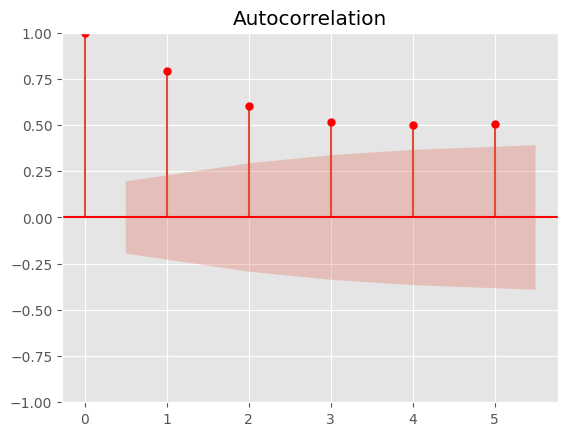

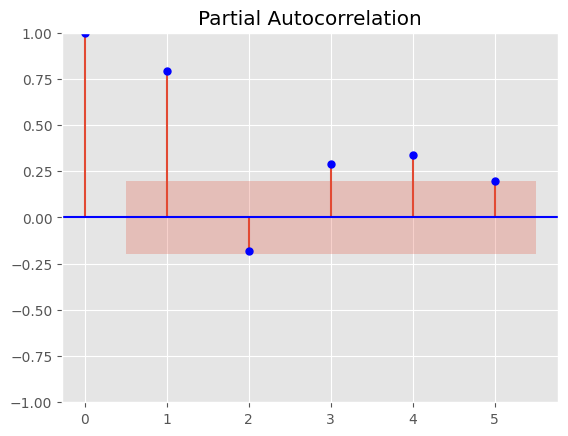

In [235]:
plot_acf(y_train, lags=5, color='r');
plot_pacf(y_train, lags=5, method='ols', color='b');

In [160]:
# Построение ARDL модели
ardl = sm.tsa.AutoReg(endog=y_train, exog=X_train, lags=1)
ardl_fitted = ardl.fit()
result = ardl_fitted.summary()
print(result)

# forecast = ardl_fitted.predict(start=len(y_train), end=len(y_train)+len(X_test)-1, exog=X_test)

                            AutoReg Model Results                             
Dep. Variable:              inflation   No. Observations:                  103
Model:                   AutoReg-X(1)   Log Likelihood                   6.962
Method:               Conditional MLE   S.D. of innovations              0.226
Date:                Sun, 20 Apr 2025   AIC                             18.077
Time:                        20:35:29   BIC                             60.076
Sample:                             1   HQIC                            35.084
                                  103                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0815      0.039      2.116      0.034       0.006       0.157
inflation.L1      0.8135      0.057     14.163      0.000       0.701       0.926
debt_firms       -0.0436      0.100     

## Prophet


In [165]:
X_train

,debt_firms,debt_fiz,Brent,MIACR,obligates,paid_services,salary,M2,gov_debt,Infl_exp,PCA_1,PCA_2,PCA_3
0,9.48,11.64,-8.74,1.25,0.91,0.43,-2.07,-0.26,0.62,0.45,0.84,-0.90,0.29
1,3.08,0.82,-4.95,1.24,1.03,0.19,2.80,0.35,0.59,0.99,0.45,-0.44,0.38
2,0.77,0.54,-5.23,0.68,0.83,0.18,0.15,-2.21,-1.06,0.56,0.93,0.10,0.31
3,0.35,0.24,-5.53,1.06,0.47,0.06,0.04,2.20,1.10,-0.37,0.68,0.38,0.31
4,0.20,0.21,-2.85,0.57,0.37,-0.06,0.19,0.14,0.80,0.51,-0.39,0.01,-0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,0.01,0.02,-1.99,0.31,-0.64,0.02,0.02,0.04,0.02,-0.84,1.73,0.20,-0.72
95,0.01,0.02,7.86,0.68,-1.02,0.05,0.01,0.03,0.02,0.65,6.63,-3.92,-0.23
96,0.06,0.03,6.94,1.00,-0.83,0.04,0.02,0.02,0.01,3.07,0.30,1.36,3.29
97,0.02,0.00,17.56,7.12,-1.03,0.07,0.10,0.03,0.00,-3.49,-3.72,4.07,-0.24


00:54:34 - cmdstanpy - INFO - Chain [1] start processing
00:54:35 - cmdstanpy - INFO - Chain [1] done processing


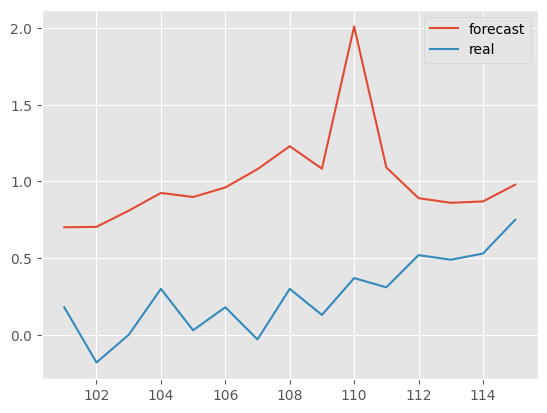

In [236]:
df_prophet = df.loc[:len(X_train), ['date', 'inflation']].copy()
df_prophet.columns = ['ds', 'y']
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

prophet_model = Prophet(interval_width=0.95)
prophet_model.fit(df_prophet)
future = prophet_model.make_future_dataframe(periods=len(y_test), freq='M')
prophet_pred = prophet_model.predict(future)
prophet_pred.iloc[-len(y_test)-1:-1]['yhat'].plot(label='forecast')
y_test.plot(label='real')
plt.legend()

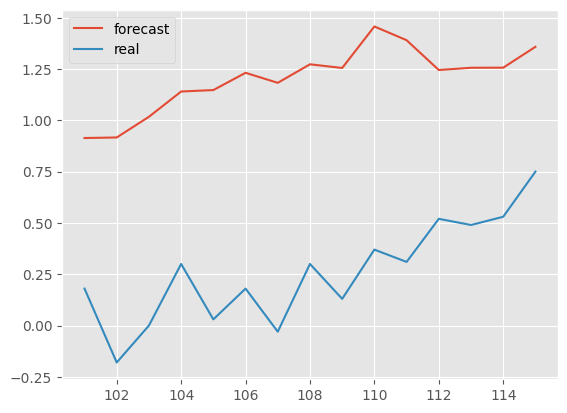

In [237]:
nprophet_model = NeuralProphet()
metrics = nprophet_model.fit(df_prophet, freq="M")
future_df = nprophet_model.make_future_dataframe(df_prophet,
                                                 periods=len(y_test),
                                                 n_historic_predictions=len(df_prophet))
preds_df_2 = nprophet_model.predict(future_df)
clear_output(wait=False)
preds_df_2.iloc[-len(y_test)-1:-1]['yhat1'].plot(label='forecast');
y_test.plot(label='real');
plt.legend()

## SARIMA


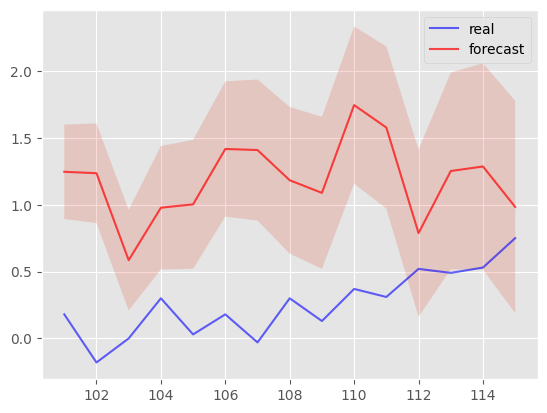

In [239]:
mod_sarimax = sm.tsa.SARIMAX(y_train, exog=X_train, order=(1,1,5), seasonal_order=(1,1,5,12))
res_sarimax = mod_sarimax.fit()

clear_output(wait=False)
forecast_sarimax = res_sarimax.get_forecast(steps=len(y_test), exog=X_test)
pred_sarimax = forecast_sarimax.predicted_mean
conf_int_sarimax = forecast_sarimax.conf_int()

plt.plot(y_test.index, y_test, label='real', color='b', alpha=0.6);
plt.plot(y_test.index, pred_sarimax, label='forecast', color='r', alpha=0.7);
plt.fill_between(y_test.index, conf_int_sarimax['lower inflation'], conf_int_sarimax['upper inflation'], alpha=0.2);
plt.legend();

## ETS


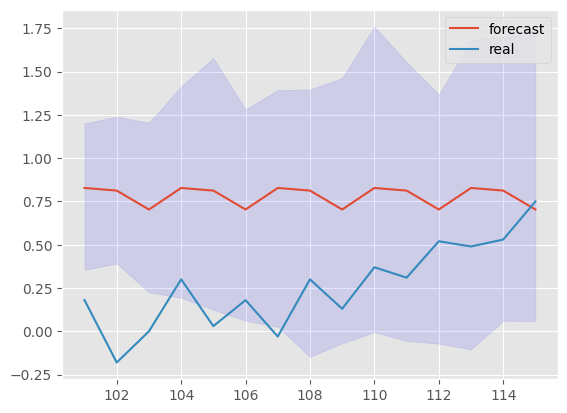

In [240]:

ets = ExponentialSmoothing(y_train, seasonal='mul', seasonal_periods=3).fit()
ets_forecast = ets.forecast(len(y_test))
num_simulations = 5000
confidence_interval = .95

simulated_forecasts = np.array([ets.simulate(len(y_test)) for _ in range(len(y_test))])

lower_bound = np.percentile(simulated_forecasts, (1 - confidence_interval) / 2 * 100, axis=0)
upper_bound = np.percentile(simulated_forecasts, (1 + confidence_interval) / 2 * 100, axis=0)
ets_conf_int = np.array(list(zip(lower_bound, upper_bound)))
ets_forecast.plot(label='forecast')
y_test.plot(label='real')
plt.legend()
plt.fill_between(range(len(y_train), len(y_train)+len(y_test)),
                 ets_conf_int[:, 0], ets_conf_int[:, 1], alpha=0.1, color='blue');

## STL + ARIMA


In [244]:
raw_data = pd.read_csv('regional_data/infl_Российская_Федерация.csv')
# a_train = raw_data.iloc[:97]['inflation']
# a_test = raw_data.iloc[97:]['inflation']

a_train = y_train.copy()
a_test = y_test.copy()


101    0.18
102   -0.18
103    0.00
104    0.30
105    0.03
106    0.18
107   -0.03
108    0.30
109    0.13
110    0.37
111    0.31
112    0.52
113    0.49
114    0.53
115    0.75
Name: inflation, dtype: float64

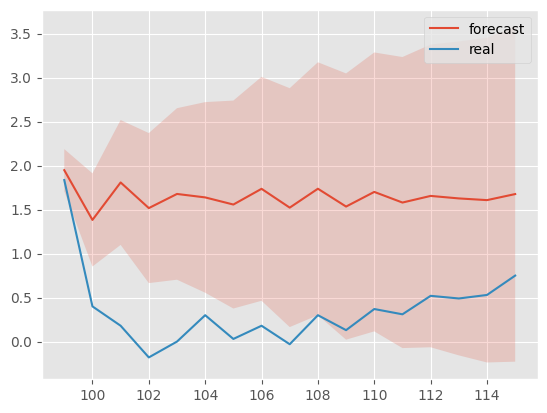

In [221]:
# удаляем сезонность в тренировочных данных
stl_train = STL(y_train, period=2)
res_train = stl_train.fit()
# Моделируем АРИМУ на тренировочных данных
arima_model = auto_arima((res_train.trend + res_train.resid),
                         seasonal=False, stepwise=True)
# Удаляем сезонность в тестовых данных
stl_test = STL(y_test, period=2)
res_test = stl_test.fit()
# Предсказываем значения с помощью модели
arima_forecast = arima_model.predict(n_periods=len(y_test), return_conf_int=True)
# Корректируем предсказание, добавляя сезонную компоненту
stl_arima_pred = arima_forecast[0] + res_test.seasonal[-len(a_test):]
num = a_test
# CI создаем массив для графика
stl_arima_conf_int = np.column_stack([
    arima_forecast[1][:, 0] + res.seasonal.values,
    arima_forecast[1][:, 1] + res.seasonal.values
])


stl_arima_pred.plot(label='forecast')
a_test.plot(label='real')
plt.legend();
plt.fill_between(a_test.index,
                 stl_arima_conf_int[:, 0],
                 stl_arima_conf_int[:, 1],
                 alpha=0.2);

## XGBoost


Mean Squared Error: 0.2088
Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


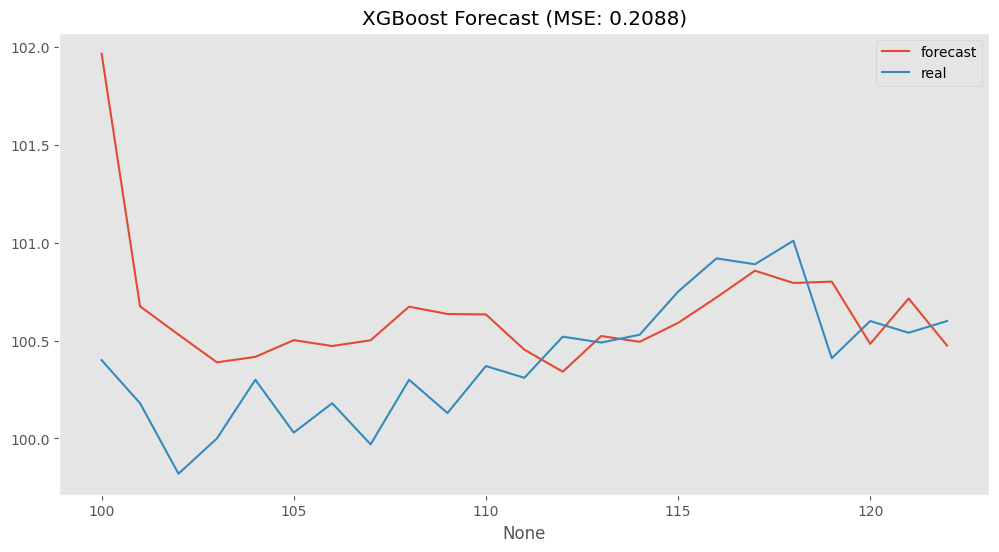

In [138]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

def create_features(df, target_col='inflation', n_lags=3, window_size=3):
    """
    Создает временные признаки для модели:
    - Лаги (авторегрессионная компонента)
    - Скользящие статистики
    - Временные фичи из даты
    """
    df = df.copy()
    
    # 1. Авторегрессионные компоненты (лаги)
    for lag in range(1, n_lags+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    
    # 2. Скользящие статистики
    df['rolling_mean'] = df[target_col].rolling(window=window_size).mean().shift(1)
    df['rolling_std'] = df[target_col].rolling(window=window_size).std().shift(1)
    
    # 3. Временные фичи из даты
    df['month'] = df['ds'].dt.month
    df['quarter'] = df['ds'].dt.quarter
    df['year'] = df['ds'].dt.year
    df['days_in_month'] = df['ds'].dt.days_in_month
    
    # 4. Дополнительные преобразования
    df['time_idx'] = (df['ds'] - df['ds'].min()).dt.days
    
    return df.dropna()
# Загрузка данных
raw_data = pd.read_csv('regional_data/infl_Российская_Федерация.csv')
a_train = pd.DataFrame(raw_data.iloc[:97]['inflation'])
a_test = pd.DataFrame(raw_data.iloc[97:]['inflation'])

# Добавляем даты
a_train['ds'] = pd.date_range(start='2014-01-01', freq='M', periods=97)
a_test['ds'] = pd.date_range(start='2022-01-01', freq='M', periods=26)

# Создаем фичи для train и test
train_feats = create_features(a_train)
test_feats = create_features(a_test)

# Разделяем на X и y
X_train_1 = train_feats.drop(columns=['inflation', 'ds'])
y_train_1 = train_feats['inflation']

X_test_1 = test_feats.drop(columns=['inflation', 'ds'])
y_test_1 = test_feats['inflation']

# Настройка кросс-валидации для временных рядов
tscv = TimeSeriesSplit(n_splits=3)
# Параметры для подбора
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Инициализация и обучение модели
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search = GridSearchCV(xgb_model, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_1, y_train_1)

# Предсказание
xgb_pred = grid_search.predict(X_test_1)

# Оценка качества
mse = mean_squared_error(y_test_1, xgb_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"Best params: {grid_search.best_params_}")

# Визуализация
plt.figure(figsize=(12, 6))
sb.lineplot(x=y_test_1.index, y=xgb_pred, label='forecast')
y_test_1.plot(label='real')
plt.title(f"XGBoost Forecast (MSE: {mse:.4f})")
plt.legend()
plt.grid()
plt.show()

## Оценка качества моделей

In [153]:
# def evaluate_model(y_true, y_pred):
#     mae = mean_absolute_error(y_true, y_pred)
#     rmse = np.sqrt(mean_squared_error(y_true, y_pred))
#     mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
#     return mae, rmse, mape

# model_dict = {
#     'Prohet': prophet_pred['yhat'].iloc[-18:].values,
#     'SARIMA': sarima_pred[:18],
#     'ETS': ets_forecast[:18],
#     'STL+ARIMA': stl_arima_pred[:18] - 100,
#     'XGBoost': xgb_pred[:18] - 100
# }

# res_dict = {}

# for model in model_dict:
#     res_dict[model] = {}
#     res_dict[model]['MAE'] = evaluate_model(y_test[:18], model_dict[model])[0]
#     res_dict[model]['RMSE'] = evaluate_model(y_test[:18], model_dict[model])[1]
#     res_dict[model]['MAPE'] = evaluate_model(y_test[:18], model_dict[model])[2]
    
# pd.DataFrame(res_dict).T.sort_values('RMSE')

In [152]:
pd.DataFrame(model_dict.values()).T.plot()